In [25]:
import numpy as np
import scipy.sparse as sps
import porepy as pp
import math
import matplotlib.pyplot as plt

In [26]:
#Nx = Ny = 20
Nx=100
#phys_dims = [1,1]
phys_dims=[1]
#g = pp.CartGrid([Nx, Ny], phys_dims)
g=pp.CartGrid([Nx],phys_dims)
g.compute_geometry()

/home/dell/Scrivania/porepy/src/porepy/viz/plot_grid.py:241: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim3d(z)


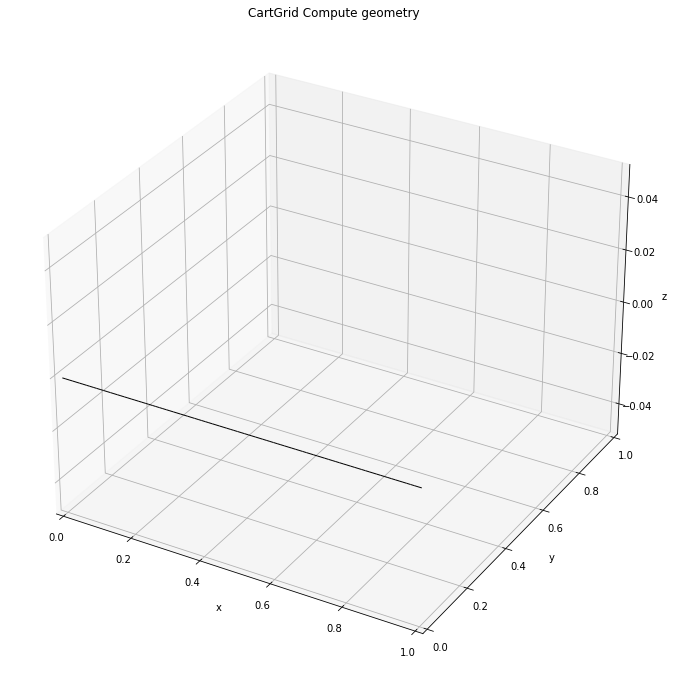

In [27]:
pp.plot_grid(g, figsize=(15, 12))

In [28]:
# Permeability
perm = pp.SecondOrderTensor(1e-7*np.ones(g.num_cells))                     

# Unitary scalar source already integrated in each cell
f = g.cell_volumes

#source= lambda x: 0.1
source= lambda x: math.sin(4*math.pi*x)
h=1/Nx
x=np.linspace(1/(2*Nx),1-1/(2*Nx),Nx)
x_vel=np.linspace(0,1,Nx+1)
f=np.zeros(Nx)
for i in range(Nx):
    f[i]=h*source(x[i])

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
bc_val = np.zeros(g.num_faces)
bc_val[0]=1e6
bc_val[bc_val.size-1]=-800000.0

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}

In [29]:
data_key = "flow"
data = pp.initialize_default_data(g, {}, data_key, parameters)

In [30]:
flow_discretization = pp.MVEM("flow")
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

rhs_discretization = pp.DualScalarSource("flow")

data[pp.PARAMETERS]["flow"]["source"] = data[pp.PARAMETERS]["flow"]["source"]
rhs_discretization.discretize(g, data)
_, b_rhs = rhs_discretization.assemble_matrix_rhs(g, data)

up = sps.linalg.spsolve(A, b_flow+b_rhs)                                              

# Extract the normal flux and pressure from the solution
u_mvem = flow_discretization.extract_flux(g, up, data)
p_mvem = flow_discretization.extract_pressure(g, up, data) 

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = flow_discretization.project_flux(g, u_mvem, data)

In [31]:
#pp.plot_grid(g, p_tpfa, figsize=(15, 12))

[ 994997.19040736  984928.53314155  974671.75578233  964104.7430831
  953110.27239385  941577.86233247  929405.51514206  916501.32525655
  902784.92870634  888188.77050613  872659.17003739  856157.16762375
  838659.13894842  820157.16762375  800659.17003739  780188.77050613
  758784.92870634  736501.32525655  713405.51514206  689577.86233247
  665110.27239386  640104.74308311  614671.75578235  588928.53314156
  562997.19040737  537002.80959265  511071.46685846  485328.24421768
  459895.25691691  434889.72760616  410422.13766755  386594.48485796
  363498.67474347  341215.07129368  319811.22949389  299340.82996263
  279842.83237627  261340.8610516   243842.83237627  227340.82996263
  211811.22949388  197215.07129368  183498.67474347  170594.48485796
  158422.13766755  146889.72760616  135895.25691691  125328.24421767
  115071.46685846  105002.80959265   94997.19040737   84928.53314156
   74671.75578234   64104.7430831    53110.27239386   41577.86233247
   29405.51514206   16501.32525655 

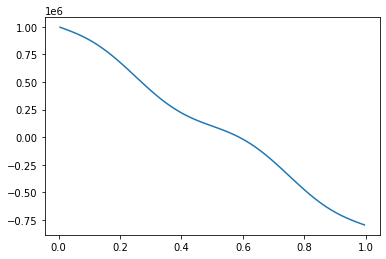

In [32]:
print(p_mvem)
plt.plot(x,p_mvem)

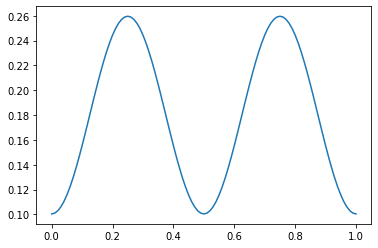

In [33]:
plt.plot(x_vel,u_mvem)